In [23]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
from VGG_19 import VGG19
import os
import shutil
import numpy as np

# Q1

In [24]:
# Define the function and its derivatives
def func(x, y):
    return pow(x, 2) + pow(y, 2) + x*y + 2*x + math.cos(3*x)

def derivative_x(x, y):
    return 2*x + y + 2 - 3*math.sin(3*x)

def derivative_y(x, y):
    return 2*y + x

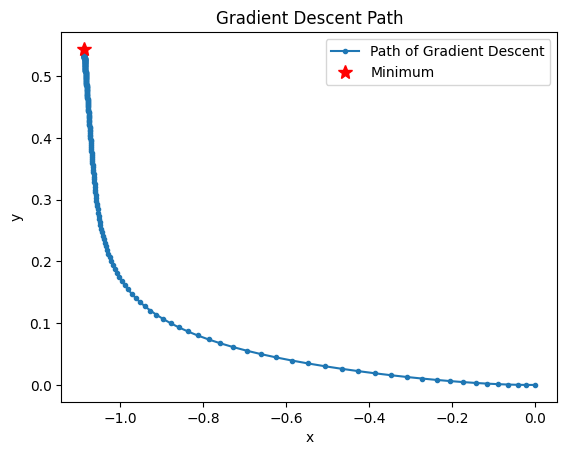

min_x:  -1.088156592554671  min_y:  0.5440286008422788  functions_value:  -2.2807097055009007


In [25]:
# Gradient Descent Implementation
def gradient_descent(derivative_func_x, derivative_func_y, initial_x, initial_y, learning_rate, max_iterations, tolerance):
    x, y = initial_x, initial_y
    path = [(x, y)] # to store the path of gradient descent
    
    for _ in range(max_iterations):
        grad_x = derivative_func_x(x, y)
        grad_y = derivative_func_y(x, y)
        
        # Update x and y
        x_new = x - learning_rate * grad_x
        y_new = y - learning_rate * grad_y
        
        # Store the new values in the path
        path.append((x_new, y_new))
        
        # Check for convergence
        if math.sqrt((x_new - x)**2 + (y_new - y)**2) < tolerance:
            break
        
        x, y = x_new, y_new
    
    return x, y, path

# Initial parameters for gradient descent
initial_x = 0
initial_y = 0
learning_rate = 0.01
max_iterations = 1000
tolerance = 1e-6

# Run gradient descent
minimum_x, minimum_y, path = gradient_descent(derivative_x, derivative_y, initial_x, initial_y, learning_rate, max_iterations, tolerance)

# Plotting the results
path = np.array(path) # Convert path to numpy array for easier plotting
plt.plot(path[:, 0], path[:, 1], '-o', markersize=3, label='Path of Gradient Descent')
plt.plot(minimum_x, minimum_y, 'r*', markersize=10, label='Minimum')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Gradient Descent Path')
plt.legend()
plt.show()

print("min_x: ",minimum_x," min_y: ", minimum_y, " functions_value: ",func(minimum_x, minimum_y))


# Q2

### Read the data & Prepare

In [26]:
# spliting the data into train and test folders
def split_data(source_dir, train_dir, test_dir, train_size=0.8):
    classes = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]
    for cls in classes:
        # Create directories
        os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(test_dir, cls), exist_ok=True)
        
        # List all files in the class directory
        files = [os.path.join(source_dir, cls, f) for f in os.listdir(os.path.join(source_dir, cls))]
        np.random.shuffle(files)
        
        # Split files
        train_end = int(len(files) * train_size)
        train_files = files[:train_end]
        test_files = files[train_end:]
        
        # Copy files to respective directories
        for f in train_files:
            shutil.copy(f, os.path.join(train_dir, cls))
        for f in test_files:
            shutil.copy(f, os.path.join(test_dir, cls))

In [27]:
#split_data("250000_Final", "train", "test")

In [28]:
# Prepare  data
datagen = ImageDataGenerator(
    validation_split=0.2  # Setting validation split to 20%
)

train_generator = datagen.flow_from_directory(
    'train',
    target_size=(32, 32),
    batch_size=128,
    class_mode='categorical',
    subset='training'  # Specify subset as training
)

validation_generator = datagen.flow_from_directory(
    'train',
    target_size=(32, 32),
    batch_size=128,
    class_mode='categorical',
    subset='validation'  # Specify subset as validation
)

test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    'test',
    target_size=(32, 32),
    batch_size=128,
    class_mode='categorical',
    shuffle=False
)

Found 161831 images belonging to 10 classes.
Found 40453 images belonging to 10 classes.
Found 50576 images belonging to 10 classes.


### VGG-19

In [29]:
# Initialize the model
model = VGG19(include_top=True, weights=None, input_shape=(32, 32, 3), classes=10).model

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

# Define the Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)


# Train the model
history = model.fit(
      train_generator,
      epochs=5,
      validation_data=validation_generator,
      verbose=2,
      callbacks=[early_stopping]).history


Epoch 1/5
1265/1265 - 695s - 549ms/step - accuracy: 0.8700 - loss: 0.3743 - val_accuracy: 0.9716 - val_loss: 0.1027
Epoch 2/5
1265/1265 - 692s - 547ms/step - accuracy: 0.9832 - loss: 0.0617 - val_accuracy: 0.9826 - val_loss: 0.0686
Epoch 3/5
1265/1265 - 694s - 549ms/step - accuracy: 0.9894 - loss: 0.0426 - val_accuracy: 0.9814 - val_loss: 0.0740
Epoch 4/5
1265/1265 - 691s - 546ms/step - accuracy: 0.9908 - loss: 0.0378 - val_accuracy: 0.9791 - val_loss: 0.0811
Epoch 5/5
1265/1265 - 689s - 545ms/step - accuracy: 0.9931 - loss: 0.0296 - val_accuracy: 0.9831 - val_loss: 0.0714
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


In [30]:
model.save("VGG19.h5")

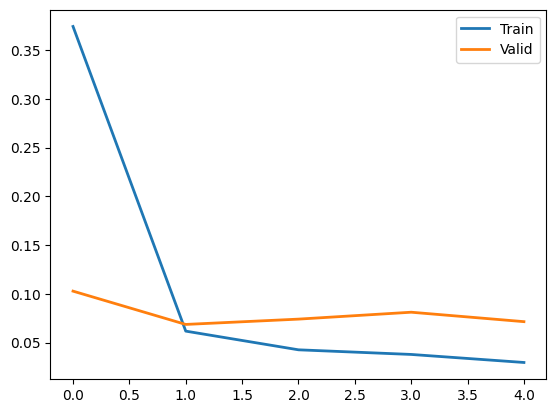

In [31]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')

In [32]:
# Predict on the test set
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size+1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

396/396 ━━━━━━━━━━━━━━━━━━━━ 38s 97ms/step


In [33]:
# Calculate metrics
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# print the classification report
print("Classification repot for VGG19: \n",report)

Classification repot for VGG19: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      5008
           1       0.99      0.98      0.99      5001
           2       0.99      0.99      0.99      5031
           3       0.99      0.99      0.99      5010
           4       0.99      0.99      0.99      5082
           5       0.97      1.00      0.98      5138
           6       0.99      0.98      0.99      5142
           7       0.97      0.99      0.98      5069
           8       0.99      0.98      0.98      5073
           9       0.98      0.98      0.98      5022

    accuracy                           0.99     50576
   macro avg       0.99      0.99      0.99     50576
weighted avg       0.99      0.99      0.99     50576



In [34]:
conf_matrix

array([[4959,    3,    1,    5,    1,    3,    7,    2,   16,   11],
       [   9, 4899,   10,    2,   21,    0,   14,   37,    2,    7],
       [   1,    0, 4975,    6,    2,    4,    0,   11,    7,   25],
       [   0,    0,    4, 4946,    8,   24,    0,   10,    4,   14],
       [   3,   12,    5,    1, 5018,    5,    4,   16,    2,   16],
       [   0,    0,    0,   14,    0, 5116,    3,    1,    3,    1],
       [   4,    5,    0,    0,    0,   74, 5045,    2,   12,    0],
       [   1,    6,    1,    1,    5,    7,    4, 5030,    3,   11],
       [   2,    0,   26,   23,    3,   44,    7,    5, 4954,    9],
       [   1,    2,   16,    4,    3,    2,    1,   73,    1, 4919]],
      dtype=int64)

### ResNet50

In [35]:
base_model = ResNet50(weights=None, include_top=False, input_shape=(32, 32, 3))


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)


model_resnet = Model(inputs=base_model.input, outputs=predictions)


model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_resnet.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    verbose=2
).history

Epoch 1/5
1265/1265 - 510s - 403ms/step - accuracy: 0.8582 - loss: 0.4656 - val_accuracy: 0.8881 - val_loss: 0.3523
Epoch 2/5
1265/1265 - 495s - 392ms/step - accuracy: 0.9732 - loss: 0.0880 - val_accuracy: 0.9438 - val_loss: 0.1815
Epoch 3/5
1265/1265 - 504s - 398ms/step - accuracy: 0.9802 - loss: 0.0684 - val_accuracy: 0.9619 - val_loss: 0.1363
Epoch 4/5
1265/1265 - 514s - 407ms/step - accuracy: 0.9840 - loss: 0.0572 - val_accuracy: 0.9108 - val_loss: 0.3155
Epoch 5/5
1265/1265 - 495s - 391ms/step - accuracy: 0.9852 - loss: 0.0534 - val_accuracy: 0.9431 - val_loss: 0.2293


In [36]:
model_resnet.save("ResNet_50.h5")

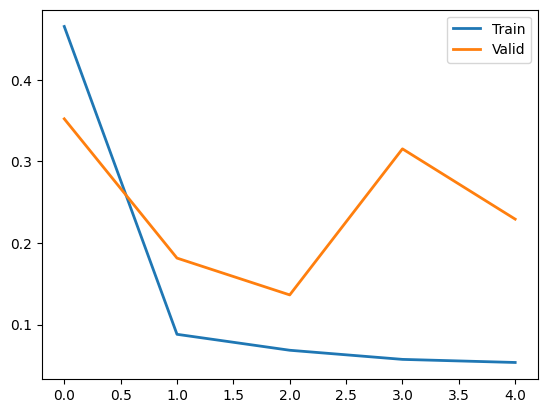

In [37]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')

In [38]:
# Predict on the test set
predictions = model_resnet.predict(test_generator, steps=test_generator.samples // test_generator.batch_size+1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

396/396 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step


In [39]:
# Calculate metrics
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# print the classification report
print("Classification repot for ResNet50: \n",report)

Classification repot for ResNet50: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      5008
           1       0.96      0.97      0.97      5001
           2       1.00      0.87      0.93      5031
           3       0.98      0.90      0.94      5010
           4       0.94      0.98      0.96      5082
           5       0.97      0.98      0.98      5138
           6       0.95      0.99      0.97      5142
           7       0.90      0.97      0.94      5069
           8       0.98      0.92      0.95      5073
           9       0.90      0.97      0.93      5022

    accuracy                           0.95     50576
   macro avg       0.96      0.95      0.95     50576
weighted avg       0.96      0.95      0.95     50576



In [40]:
conf_matrix

array([[4910,   15,    0,    3,   10,    5,   14,   15,    7,   29],
       [   7, 4873,    7,    0,   36,    1,   26,   45,    0,    6],
       [   4,   40, 4374,    9,  113,    8,   19,  122,   77,  265],
       [  14,   12,    1, 4524,   87,   69,    4,  151,    9,  139],
       [   1,   20,    2,    0, 4993,    3,    4,   45,    4,   10],
       [   0,   12,    0,   26,    7, 5035,   24,   18,    4,   12],
       [  23,   10,    0,    0,    1,   28, 5077,    1,    2,    0],
       [   0,   38,    0,    0,   21,    4,   21, 4938,    2,   45],
       [  20,   24,    1,   57,   38,   26,  166,   51, 4672,   18],
       [   5,   13,    3,    7,   29,    1,    2,  103,    9, 4850]],
      dtype=int64)

### DenseNet-121

In [41]:
# initialize the model DenseNet
model_densenet = DenseNet121(weights=None, include_top=False, input_shape=(32, 32, 3))

x = model_densenet.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x) 
predictions = Dense(train_generator.num_classes, activation='softmax')(x)


model_densenet = Model(inputs=model_densenet.input, outputs=predictions)


model_densenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_densenet.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    verbose=2
).history

Epoch 1/5
1265/1265 - 319s - 252ms/step - accuracy: 0.9314 - loss: 0.2119 - val_accuracy: 0.9344 - val_loss: 0.2089
Epoch 2/5
1265/1265 - 285s - 225ms/step - accuracy: 0.9833 - loss: 0.0579 - val_accuracy: 0.9585 - val_loss: 0.1429
Epoch 3/5
1265/1265 - 282s - 223ms/step - accuracy: 0.9876 - loss: 0.0434 - val_accuracy: 0.9275 - val_loss: 0.2333
Epoch 4/5
1265/1265 - 287s - 227ms/step - accuracy: 0.9895 - loss: 0.0374 - val_accuracy: 0.9735 - val_loss: 0.0977
Epoch 5/5
1265/1265 - 287s - 227ms/step - accuracy: 0.9912 - loss: 0.0310 - val_accuracy: 0.9779 - val_loss: 0.0854


In [42]:
model_densenet.save("DenseNet_121.h5")

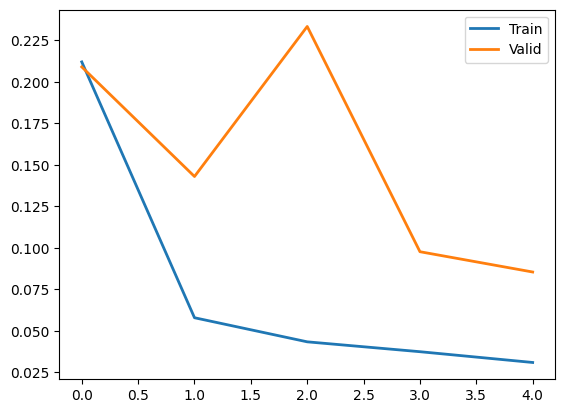

In [43]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')

In [44]:
# Predict on the test set
predictions = model_densenet.predict(test_generator, steps=test_generator.samples // test_generator.batch_size+1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

396/396 ━━━━━━━━━━━━━━━━━━━━ 26s 63ms/step


In [45]:
# Calculate metrics
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# print the classification report
print("Classification repot for DenseNet_121: \n",report)

Classification repot for DenseNet_121: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      5008
           1       0.98      0.99      0.99      5001
           2       0.99      0.97      0.98      5031
           3       1.00      0.94      0.97      5010
           4       0.99      0.99      0.99      5082
           5       0.98      0.99      0.99      5138
           6       0.99      0.99      0.99      5142
           7       0.97      0.99      0.98      5069
           8       0.99      0.99      0.99      5073
           9       0.93      0.99      0.96      5022

    accuracy                           0.98     50576
   macro avg       0.98      0.98      0.98     50576
weighted avg       0.98      0.98      0.98     50576



In [46]:
conf_matrix

array([[4928,    4,    2,    0,    2,    2,   16,    1,   10,   43],
       [   4, 4932,    8,    0,   27,    0,   13,   12,    2,    3],
       [   0,    8, 4888,    1,    1,    1,    1,   18,    4,  109],
       [   2,   14,   10, 4732,    5,   48,    1,   49,   25,  124],
       [   0,   11,    7,    0, 5014,    4,    3,   17,    5,   21],
       [   0,    4,    0,    5,    2, 5099,   15,    4,    1,    8],
       [   4,    2,    0,    0,    1,   15, 5110,    1,    9,    0],
       [   1,   21,    0,    1,    8,    1,    6, 5007,    3,   21],
       [   3,    1,    7,    2,    0,   16,    6,    3, 5015,   20],
       [   1,   12,    2,    0,    2,    0,    0,   31,    4, 4970]],
      dtype=int64)

#### My Deep learning algorithm

In [47]:
from my_model import My_model

In [48]:
# Initialize the model_my
model_my = My_model(include_top=True, weights=None, input_shape=(32, 32, 3), classes=10).model

# Compile the model_my
model_my.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

# Define the Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)


# Train the model_my
history = model_my.fit(
      train_generator,
      epochs=10,
      validation_data=validation_generator,
      verbose=2,
      callbacks=[early_stopping]).history

Epoch 1/10
1265/1265 - 117s - 92ms/step - accuracy: 0.8611 - loss: 0.4104 - val_accuracy: 0.9044 - val_loss: 0.2985
Epoch 2/10
1265/1265 - 113s - 89ms/step - accuracy: 0.9650 - loss: 0.1095 - val_accuracy: 0.9404 - val_loss: 0.1845
Epoch 3/10
1265/1265 - 161s - 127ms/step - accuracy: 0.9764 - loss: 0.0736 - val_accuracy: 0.8751 - val_loss: 0.3953
Epoch 4/10
1265/1265 - 165s - 131ms/step - accuracy: 0.9822 - loss: 0.0557 - val_accuracy: 0.9647 - val_loss: 0.1127
Epoch 5/10
1265/1265 - 113s - 89ms/step - accuracy: 0.9864 - loss: 0.0430 - val_accuracy: 0.9740 - val_loss: 0.0868
Epoch 6/10
1265/1265 - 113s - 89ms/step - accuracy: 0.9892 - loss: 0.0347 - val_accuracy: 0.9724 - val_loss: 0.0908
Epoch 7/10
1265/1265 - 114s - 90ms/step - accuracy: 0.9905 - loss: 0.0296 - val_accuracy: 0.9710 - val_loss: 0.1009
Epoch 8/10
1265/1265 - 113s - 89ms/step - accuracy: 0.9920 - loss: 0.0244 - val_accuracy: 0.9742 - val_loss: 0.0918
Epoch 8: early stopping
Restoring model weights from the end of the be

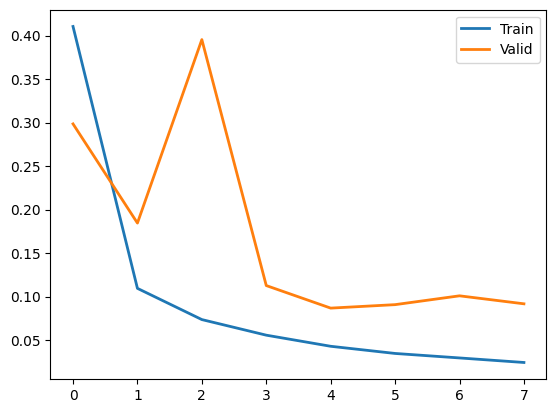

In [49]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')

In [50]:
# Predict on the test set
predictions = model_my.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

396/396 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step


In [51]:
# Calculate metrics
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# print the classification report
print("Classification repot for My model: \n",report)

Classification repot for My model: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      5008
           1       0.98      0.99      0.98      5001
           2       0.98      0.98      0.98      5031
           3       0.98      0.99      0.98      5010
           4       0.98      0.98      0.98      5082
           5       1.00      0.95      0.97      5138
           6       0.97      0.99      0.98      5142
           7       0.99      0.95      0.97      5069
           8       0.97      0.98      0.97      5073
           9       0.96      0.97      0.96      5022

    accuracy                           0.98     50576
   macro avg       0.98      0.98      0.98     50576
weighted avg       0.98      0.98      0.98     50576



In [52]:
conf_matrix

array([[4966,    3,    3,    4,    2,    2,   16,    0,    4,    8],
       [  10, 4935,    5,    0,   25,    0,   10,   10,    1,    5],
       [   3,    8, 4948,   15,    8,    0,    7,    4,   19,   19],
       [   2,    2,    8, 4961,    5,    5,    2,    3,   14,    8],
       [   2,   28,    7,    8, 4989,    3,    9,    4,   19,   13],
       [  16,    5,    7,   38,    9, 4880,  105,    5,   55,   18],
       [  13,    6,    0,    1,    1,    6, 5095,    1,   19,    0],
       [   3,   43,    3,    8,   33,    2,    7, 4812,   21,  137],
       [  15,    2,   15,   20,    4,    5,   27,    1, 4974,   10],
       [   3,   20,   40,   17,   11,    0,    0,   24,   23, 4884]],
      dtype=int64)